In [7]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import trange
from flygym.arena import OdorArena
from flygym.util import get_data_path
from flygym.preprogrammed import all_leg_dofs
from flygym import Fly, Camera, SingleFlySimulation

Load recorded kinematics

In [8]:
run_time = 1
timestep = 1e-4
actuated_joints = all_leg_dofs

# Load recorded data
data_path = get_data_path("flygym", "data")
with open(data_path / "behavior" / "210902_pr_fly1.pkl", "rb") as f:
    data = pickle.load(f)

# Interpolate 5x
num_steps = int(run_time / timestep)
data_block = np.zeros((len(actuated_joints), num_steps))
measure_t = np.arange(len(data["joint_LFCoxa"])) * data["meta"]["timestep"]
interp_t = np.arange(num_steps) * timestep
for i, joint in enumerate(actuated_joints):
    data_block[i, :] = np.interp(interp_t, measure_t, data[joint])

Initialize simulation

In [12]:
fly = Fly(
    enable_olfaction=True,
    actuated_joints=actuated_joints,
)

cam = Camera(
    fly=fly,
    play_speed=0.1,
)

odor_source = [[2, -1, 1.5], [5, 1, 1.5]]
peak_odor_intensity = [[80, 0], [0, 100]]

arena = OdorArena(
    odor_source=odor_source,
    peak_odor_intensity=peak_odor_intensity,
    diffuse_func=lambda x: x**-2,
)

sim = SingleFlySimulation(
    fly=fly,
    cameras=[cam],
    arena=arena,
    timestep=1e-4,
)

Run simulation

In [13]:
obs_list = []
for i in trange(num_steps):
    joint_pos = data_block[:, i]
    action = {"joints": joint_pos}
    obs, reward, terminated, truncated, info = sim.step(action)
    sim.render()
    obs_list.append(obs)
sim.close()

100%|██████████| 10000/10000 [00:21<00:00, 472.58it/s]


AttributeError: 'SingleFlySimulation' object has no attribute 'save_video'

In [14]:
cam.save_video("outputs/odor_arena_kin_replay.mp4")

Text(0.5, 1.0, 'Arena layout')

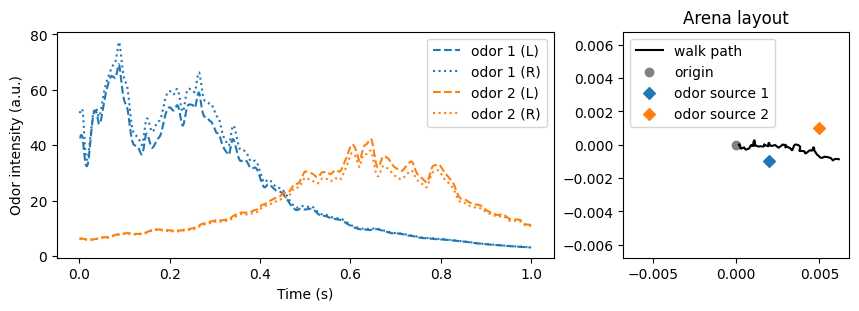

In [5]:
fly_pos = np.array([obs["fly"] for obs in obs_list])[:, 0, :]
fly_orient = np.array([obs["fly"] for obs in obs_list])[:, 2, :]
odor = np.array([obs["odor_intensity"] for obs in obs_list])

axd = plt.figure(constrained_layout=True, figsize=(9, 3)).subplot_mosaic(
    """
    AAABB
    """
)
t = np.arange(num_steps) * sim.timestep

ax = axd["A"]
ax.plot(t, odor[:, 0, 0], linestyle="--", color="tab:blue", label="odor 1 (L)")
ax.plot(t, odor[:, 0, 1], linestyle=":", color="tab:blue", label="odor 1 (R)")
ax.plot(t, odor[:, 1, 0], linestyle="--", color="tab:orange", label="odor 2 (L)")
ax.plot(t, odor[:, 1, 1], linestyle=":", color="tab:orange", label="odor 2 (R)")
ax.legend(loc="upper right")
ax.set_ylabel("Odor intensity (a.u.)")
ax.set_xlabel("Time (s)")

ax = axd["B"]
max_extent = max(fly_pos[:, :2].max(), arena.odor_source[:, :2].max()) * 1.1 / 1000
ax.plot(fly_pos[:, 0] / 1000, fly_pos[:, 1] / 1000, color="black", label="walk path")
ax.scatter([0], [0], marker="o", color="gray", label="origin")
ax.scatter(
    [odor_source[0][0] / 1000],
    [odor_source[0][1] / 1000],
    color="tab:blue",
    marker="D",
    label="odor source 1",
)
ax.scatter(
    [odor_source[1][0] / 1000],
    [odor_source[1][1] / 1000],
    color="tab:orange",
    marker="D",
    label="odor source 2",
)
ax.legend(loc="upper left")
ax.set_xlim(-max_extent, max_extent)
ax.set_ylim(-max_extent, max_extent)
ax.set_aspect("equal")
ax.set_title("Arena layout")